# Or Query Vs Or Calculate

In [1]:
%matplotlib inline

from pymongo import MongoClient
import random
import time

URL = None
DATABASE = "yummly"
RECIPES_COLLECTION = "recipesWAt"
COMBINATIONS_COLLECTION = "combinationsWAt"
SAMPLE_SIZE = 100
RAND_SEED = 10
RMIN = 1
RMAX = 4

client = MongoClient(URL) if URL else MongoClient()
db = client[DATABASE]
recipes_coll = db[RECIPES_COLLECTION]
combinations_coll = db[COMBINATIONS_COLLECTION]


random.seed(RAND_SEED)
samples = {}
for r in range(RMIN, RMAX + 1):
    
    # get count of recipes containing r or more ingredients
    sample_filter = {
        "$where": "this.ingredients.length >= {r} && this.ingredients.length <= {RMAX}".format(r=r, RMAX=RMAX)
    }
    count = recipes_coll.count(sample_filter)
    
    # get sorted list of SAMPLE_SIZE random indexes of value < r
    to_sample = random.sample(range(0,count), SAMPLE_SIZE)
    to_sample.sort()
    
    # get the recipes at the random indexes
    cursor = recipes_coll.find(sample_filter)
    position = 0
    samples[r] = []
    for index in to_sample:
        while position <= index:
            record = cursor.next()
            position += 1
        
        # and extract a random combination from the recipe's ingredients
        ingredients = list(record['ingredients'])
        random.shuffle(ingredients)
        samples[r].append(ingredients[:r])

print(samples)

{1: [['beef broth'], ['cooking spray'], ['butter'], ['eggs'], ['coarse salt'], ['chia seeds'], ['popcorn kernels'], ['butter'], ['extra-virgin olive oil'], ['sourdough starter'], ['strawberries'], ['sweet potatoes'], ['bacon'], ['fresh mozzarella'], ['mayonnaise'], ["Hellmann's or Best Foods Real Mayonnaise"], ['cinnamon'], ['boneless skinless chicken breast halves'], ['sea salt'], ['frozen meatballs'], ['cayenne pepper'], ['chicken breasts'], ['jalapeno chilies'], ['melted butter'], ['kosher salt'], ['dried pasta'], ['frozen cheese ravioli'], ['sugar'], ['baguette'], ['tart apples'], ['green onions'], ['feta'], ['pumpkin'], ['green beans'], ['pepperoni'], ['cane syrup'], ['poblano chilies'], ['yeast'], ['garlic cloves'], ['gelatin dessert'], ['green bell pepper'], ['buttermilk biscuits'], ['asparagus'], ['eggs'], ['Pace Picante Sauce'], ['sea salt'], ['herbs'], ['cream cheese'], ['fat'], ['pepper'], ['seasoning mix'], ['salad dressing'], ['butter'], ['butter'], ['Brussels sprouts'], [

## Query Or-Counts

In [14]:
or_times = {}

for r in sorted(samples, reverse=True):
    combos = samples[r]
    or_times[r] = []
    for ingredients in combos:
        start = time.time()

        and_count = db[RECIPES_COLLECTION].find({
            "ingredients": {
                "$in": ingredients
            }
        }).count()

        end = time.time()
        or_times[r].append(end - start)

print(or_times)

{1: [0.00096893310546875, 0.002871274948120117, 0.010756731033325195, 0.008982419967651367, 0.0017545223236083984, 0.0005428791046142578, 0.00044035911560058594, 0.013946056365966797, 0.008666038513183594, 0.00055694580078125, 0.0014832019805908203, 0.002422809600830078, 0.0029680728912353516, 0.0006310939788818359, 0.00457000732421875, 0.0005311965942382812, 0.0023641586303710938, 0.0005109310150146484, 0.0027360916137695312, 0.00047397613525390625, 0.0025000572204589844, 0.001554250717163086, 0.0025446414947509766, 0.0017118453979492188, 0.0068302154541015625, 0.0005295276641845703, 0.0004172325134277344, 0.011522054672241211, 0.0009238719940185547, 0.0005321502685546875, 0.0055239200592041016, 0.0006763935089111328, 0.0006418228149414062, 0.0011811256408691406, 0.0006234645843505859, 0.00032401084899902344, 0.00041747093200683594, 0.000904083251953125, 0.01233363151550293, 0.0005877017974853516, 0.0017583370208740234, 0.00045871734619140625, 0.0011243820190429688, 0.0104544162750244

## Calculate Or-Counts

In [15]:
import itertools

calc_times = {}

for r in sorted(samples, reverse=True):
    combos = samples[r]
    calc_times[r] = []
    for ingredients in combos:
        start = time.time()

        or_count = 0
        add_sub = 1
        for r in range(1, len(ingredients) + 1):
            combinations = itertools.combinations(ingredients, r)
            for c in combinations:
                c = list(c)
                c.sort()
                c_id = '::'.join(c)
                and_count = combinations_coll.find_one({"_id": c_id})['and_count']
                or_count += and_count * add_sub
            add_sub *= -1

        end = time.time()
        calc_times[r].append(end - start)

print(calc_times)




{1: [0.0016045570373535156, 0.003291606903076172, 0.005501985549926758, 0.0051500797271728516, 0.0024895668029785156, 0.0008449554443359375, 0.00046324729919433594, 0.004910469055175781, 0.003992319107055664, 0.0006117820739746094, 0.001529693603515625, 0.00222015380859375, 0.002932310104370117, 0.0010254383087158203, 0.002985239028930664, 0.0007383823394775391, 0.002300262451171875, 0.0007727146148681641, 0.003134012222290039, 0.0004620552062988281, 0.0032629966735839844, 0.002218008041381836, 0.0026123523712158203, 0.0019428730010986328, 0.0040280818939208984, 0.0006282329559326172, 0.00040078163146972656, 0.00456547737121582, 0.0017189979553222656, 0.0009784698486328125, 0.003561258316040039, 0.001026153564453125, 0.0012040138244628906, 0.0018787384033203125, 0.0010116100311279297, 0.0005750656127929688, 0.0005335807800292969, 0.0010688304901123047, 0.004995822906494141, 0.0005481243133544922, 0.002415180206298828, 0.0006718635559082031, 0.0018384456634521484, 0.004420757293701172, 

## Compare Query Times

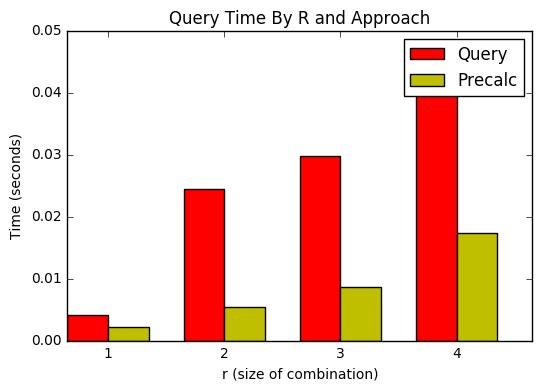

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# http://matplotlib.org/examples/api/barchart_demo.html

N = len(or_times.keys())
preMeans = [sum(or_times[r]) / float(len(or_times[r])) for r in sorted(or_times.keys())]
#calculate standard deviation
preStd = None

ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, preMeans, width, color='r')

otfMeans = [sum(calc_times[r]) / float(len(calc_times[r])) for r in sorted(calc_times.keys())]
otfStd = None
rects2 = ax.bar(ind + width, otfMeans, width, color='y')

ax.set_ylabel('Time (seconds)')
ax.set_xlabel('r (size of combination)')
ax.set_title('Query Time By R and Approach')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

ax.legend((rects1[0], rects2[0]), ('Query', 'Precalc'))

plt.show()